# The Ultimate Guide On RAG

Hello Kagglers! RAG, which stands for Retrieval Augmented Generation, is a technique used to enhance the knowledge base of large language models (LLMs) through the integration of external information. By doing so, LLMs are equipped to generate more context-aware responses and reduce instances of hallucination. This guide aims to offer an in-depth exploration of the RAG process.

First Let's look at some reasons why we may need RAG. 

In [24]:
%%capture
!mamba install cudatoolkit xformers bitsandbytes pytorch pytorch-cuda=11.8 \
    -c pytorch -c nvidia -c xformers -c conda-forge -y
!pip install "unsloth[kaggle] @ git+https://github.com/unslothai/unsloth.git"
!pip uninstall datasets -y
!pip install datasets
!pip install -U sentence-transformers
!pip install umap-learn
import os
os.environ["WANDB_DISABLED"] = "true"


In [25]:
!pip install xformers

In [26]:
!pip install -q bitsandbytes


In [27]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "openchat/openchat-3.5-0106-gemma", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = "" 
)

==((====))==  Unsloth: Fast Gemma patching release 2024.3
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


In [28]:
# Defining the prompt 
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [29]:
def get_response(query, input=None):
        
    inputs = tokenizer(
    [
        prompt.format(
            query, # instruction
            "", # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs,  max_new_tokens = 256, use_cache = True)
    answer = tokenizer.batch_decode(outputs)[0]
    return answer.split("Response:\n")[-1]

In [30]:
print(get_response("What are the contributions of the 'Attention is all you need' paper?"))

The 'Attention is all you need' paper, also known as the Transformer paper, made several significant contributions to the field of natural language processing and deep learning. The main contributions of this paper are:

1. Introduction of the Transformer model, which is a new type of neural network architecture that relies solely on self-attention mechanisms for both internal representation and decision-making.
2. Elimination of recurrent and convolutional layers, which were commonly used in previous models, and their replacement with the proposed self-attention mechanism.
3. Improvement in the performance of language models on a variety of tasks, such as machine translation, text summarization, and question-answering, by demonstrating that the Transformer model can achieve state-of-the-art results without the need for these traditional layers.
4. Providing a new perspective on the design of neural network architectures, as the Transformer model has since inspired many other researche

It turns out the Gemma model really hit the mark with its answer this time. Chances are, it's familiar with the super popular paper ["Attention is all you need,"](https://arxiv.org/abs/1706.03762) which likely showed up in its training data. Now, let's switch gears and check out something newer on the scene: the paper titled ["Genie: Generative Interactive Environments"](https://arxiv.org/abs/2402.15391)

In [31]:
print(get_response("What are the contributions of the 'Genie' paper?"))

The 'Genie' paper, which is a research paper on the development of a new algorithm for efficient and effective data management, has made several significant contributions to the field of computer science and data management. These contributions include:

1. The introduction of a novel algorithm for data management that is capable of providing high-performance data storage and retrieval.
2. The development of a new data model that is more efficient and flexible than traditional models.
3. The improvement of data management techniques by incorporating machine learning and other advanced techniques to optimize the performance of data management systems.
4. The identification of new research directions and opportunities for future work in the field of data management.
5. The promotion of a better understanding of the potential of data management systems in various applications, such as big data analysis, data mining, and cloud computing.

Overall, the 'Genie' paper has made a significant i

Woah! Looks like the model just spit out a bunch of random information instead of something helpful. This probably happened because Gemma isn't familiar with the "Genie" paper. It seems like this paper didn't make it into its pre-trained knowledge base.


So, what's the fix here? You might think about retraining Gemma from scratch with the latest info, but let's be real—that's a no-go. Training these massive language models like Gemma from the ground up costs a fortune in time and money! And that's exactly where RAG comes to the rescue. The beauty of RAG technology is that it saves us from having to retrain the whole massive model every single time we need it to learn something new. Instead, we can just hook up the relevant knowledge bases as extra input for the model, boosting the accuracy of its responses without breaking the bank.

## What is Retrieval Augmented Generation?

RAG, short for Retrieval Augmented Generation, enhances the capabilities of large language models (LLMs) by incorporating a retrieval step into the process. When tasked with answering a question or generating text, RAG first seeks out relevant information from a vast repository of knowledge, which could include an array of documents and web pages. This approach allows the model to refine its generated responses by integrating this retrieved information, offering a more informed output that extends beyond its pre-trained knowledge base.


picture coming from [this](https://ai.plainenglish.io/a-brief-introduction-to-retrieval-augmented-generation-rag-b7eb70982891) amazing blog post




Generally, there are 3 main steps in a RAG pipeline
- Indexing: The indexing process involves cleaning raw data and converting it to plain text from formats like PDF and HTML. This text is then divided into smaller pieces and converted into vectors. Finally, an index stores these pieces and their vectors for efficient searching.

- Retrieval: Retrieve relevant information from external sources based on user query. To find relevant information based on a user's query, the system performs a vector search or a hybrid search within a vector database. 

- Generation: When a user poses a query, RAG takes that along with the context it retrieved and feeds them both into the large language model (LLM). This process enables the LLM to produce a more informed and accurate response by considering both the user's original question and the additional information sourced from the knowledge database.

Before diving into each part, let's define what we wanto to make!

## Problem formulation

In this tutorial, I want to design a chatbot that have the ability to understand and explain basic concepts about data science, machine learning, deep learning.

But not only that I want it as my personal research assistant, with the ability to:
- Find the latest papers, and give me a short overview of these papers. 
- Explore and list all the papers of a certain topic.
- Could suggest some concepts that I could explore to understand a specific paper.


## Indexing

Let's start our exploration by zeroing in on the Indexing bit of RAG. Think of an Index as a cleverly organized digital filing cabinet, stuffed with Documents that a language model can sift through for answers. In this tutorial, we're going to use the `VectorStoreIndex` from llamaindex.

But first we need to prepare some data, in this note book, I will use the [arxiv dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv/data)!

In [32]:
# All Arxiv category codes
# Source: https://www.kaggle.com/code/artgor/arxiv-metadata-exploration

# https://arxiv.org/category_taxonomy
# https://info.arxiv.org/help/api/user-manual.html#subject_classifications


category_map = {
# These created errors when mapping categories to descriptions
'acc-phys': 'Accelerator Physics',
'adap-org': 'Not available',
'q-bio': 'Not available',
'cond-mat': 'Not available',
'chao-dyn': 'Not available',
'patt-sol': 'Not available',
'dg-ga': 'Not available',
'solv-int': 'Not available',
'bayes-an': 'Not available',
'comp-gas': 'Not available',
'alg-geom': 'Not available',
'funct-an': 'Not available',
'q-alg': 'Not available',
'ao-sci': 'Not available',
'atom-ph': 'Atomic Physics',
'chem-ph': 'Chemical Physics',
'plasm-ph': 'Plasma Physics',
'mtrl-th': 'Not available',
'cmp-lg': 'Not available',
'supr-con': 'Not available',
###

# Added
'econ.GN': 'General Economics', 
'econ.TH': 'Theoretical Economics', 
'eess.SY': 'Systems and Control', 
    
'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',             
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',               
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'
}


In [33]:
# https://www.kaggle.com/code/matthewmaddock/nlp-arxiv-dataset-transformers-and-umap

# This takes about 1 minute.
import json
import pandas as pd

cols = ['id', 'title', 'abstract', 'categories']
data = []
file_name = '/home/jordan/dev/LLM/LLM-RAG/langchain/arxiv-metadata-oai-snapshot.json'


with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['title'], doc['abstract'], doc['categories']]
        data.append(lst)

df_data = pd.DataFrame(data=data, columns=cols)

print(df_data.shape)

df_data.head()

(2440876, 4)


,id,title,abstract,categories
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA


Maybe I just care about some cs topics

In [34]:
topics = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']

filtered_data = df_data[df_data['categories'].isin(topics)]

In [35]:
len(filtered_data)

107196

In [36]:
df_data = filtered_data.sample(n=16384) # randomly sample some data for development purpose

Data preprocessing

In [37]:
# https://www.kaggle.com/code/vbookshelf/part-1-build-an-arxiv-rag-search-system-w-faiss

def get_cat_text(x):
    
    cat_text = ''
    
    # Put the codes into a list
    cat_list = x.split(' ')
    
    for i, item in enumerate(cat_list):
        
        cat_name = category_map[item]
        
        # If there was no description available
        # for the category code then don't include it in the text.
        if cat_name != 'Not available':
            
            if i == 0:
                cat_text = cat_name
            else:
                cat_text = cat_text + ', ' + cat_name
 
    # Remove leading and trailing spaces
    cat_text = cat_text.strip()
    
    return cat_text
    

df_data['cat_text'] = df_data['categories'].apply(get_cat_text)

def clean_text(x):
    
    # Replace newline characters with a space
    new_text = x.replace("\n", " ")
    # Remove leading and trailing spaces
    new_text = new_text.strip()
    
    return new_text

df_data['title'] = df_data['title'].apply(clean_text)
df_data['abstract'] = df_data['abstract'].apply(clean_text)

df_data['prepared_text'] = df_data['title'] + ' \n ' + df_data['abstract']
df_data.head()

,id,title,abstract,categories,cat_text,prepared_text
587991,1501.01243,"Un r\'esumeur \`a base de graphes, ind\'ep\'en...","In this paper we present REG, a graph-based ap...",cs.CL,Computation and Language,"Un r\'esumeur \`a base de graphes, ind\'ep\'en..."
1503441,2107.09429,BoningKnife: Joint Entity Mention Detection an...,While named entity recognition (NER) is a key ...,cs.CL,Computation and Language,BoningKnife: Joint Entity Mention Detection an...
1836670,2305.03614,Denoising-Diffusion Alignment for Continuous S...,"As a key to social good, continuous sign langu...",cs.CV,Computer Vision and Pattern Recognition,Denoising-Diffusion Alignment for Continuous S...
1013994,1808.04848,URSA: A Neural Network for Unordered Point Clo...,"This paper describes a neural network layer, n...",cs.CV,Computer Vision and Pattern Recognition,URSA: A Neural Network for Unordered Point Clo...
1719113,2209.13398,Paused Agent Replay Refresh,Reinforcement learning algorithms have become ...,cs.LG,Machine Learning,Paused Agent Replay Refresh \n Reinforcement l...


In [38]:
!pip install -q llama-index

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
from llama_index.core import Document

arxiv_documents = [Document(text=item) for item in list(df_data['prepared_text'])]

Now we already have the data, let's start creating the index!

### Creating Index with `VectorStoreIndex`

The `VectorStoreIndex` is by far the most frequently used type of Index in llamaindex. This class takes your Documents and splits them up into Nodes. Then, it creates `vector_embeddings` of the text of every node. But what is `vector_embedding`?

Vector embeddings are like turning the essence of your words into a mathematical sketch. Imagine every idea or concept in your text getting its unique numerical fingerprint. This is handy because even if two snippets of text use different words, if they're sharing the same idea, their numerical sketches—or embeddings—will be close neighbors in the numerical space. This magic is done using tools known as embedding models.

Choosing the right embedding model is crucial. It's like picking the right artist to paint your portrait; you want the one who captures you best. A great place to start is the MTEB leaderboard, where the crème de la crème of embedding models are ranked. As we have quite a large dataset, the model size matters, we don't want to wait all day for the model to extract all the vector embeddings. When I last checked, the `BAAI/bge-small-en-v1.5` model was leading the pack, especially considering its size. It could be a solid choice if you're diving into the world of text embeddings.


In [40]:
!pip install -q llama-index-embeddings-huggingface
!pip install -q llama-index-vector-stores-chroma

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
!pip install -q llama-index-llms-huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import chromadb
import torch
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext


# Create embed model
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="./models", device=device_type)

Great! Now we have to find somewhere to store all of the embeddings extracted by the model, and that's why we need a `vector store`. There are many to choose from, in this tutorial, I will choose the `chroma` vector store

In [43]:
chroma_client = chromadb.PersistentClient(path="./DB")
chroma_collection = chroma_client.get_or_create_collection("demo_arxiv")


# Create vector store
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [44]:
index = VectorStoreIndex.from_documents(
    arxiv_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
)

Generating embeddings: 100%|██████████| 2048/2048 [00:04<00:00, 488.81it/s]


Fantastic! We've successfully created a vector store for our data, laying down a solid foundation. To enhance this stage further, we could explore additional techniques like data preprocessing, text chunking, and node parsing. These methods can refine our data's quality and structure, potentially boosting our system's performance. However, to keep things straightforward and focused, we'll save these advanced topics for another time.

**Loading from vector store**

Imagine you're executing this from a different script; there's no need to go through the hassle of recalculating the embeddings for all the documents again. You can simply load them up and dive straight into the task at hand.

In [45]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="./models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="./DB")
chroma_collection = chroma_client.get_or_create_collection("demo_arxiv")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)


Now, it's time to pivot to the next crucial phase: Retrieval.

# Retrieval

In the realm of digital information retrieval, the process known as similarity search within vector databases stands out for its efficiency and precision. This begins when a user's query is transformed into a vector embedding by the `embedding model`, which must be consistent with the model used during the indexing phase to ensure compatibility. Subsequently, `VectorStoreIndex` executes a mathematical operation to arrange the embeddings according to their semantic similarity to the query. The number of embeddings returned, determined by the parameter 'k', defines the scope of the search results, commonly referred to as 'top_k'. This methodology, known as "top-k semantic retrieval," is instrumental in refining search outcomes to present the most relevant results in a structured manner.


In [46]:
query_engine = index.as_retriever(
    similarity_top_k = 5, 
    alpha=0.5,
)

In [47]:
for res in query_engine.retrieve("What are some papers about video generation using diffusion models?"):
    print(res.text)
    print("=============")

VideoControlNet: A Motion-Guided Video-to-Video Translation Framework by   Using Diffusion Model with ControlNet 
 Recently, diffusion models like StableDiffusion have achieved impressive image generation results. However, the generation process of such diffusion models is uncontrollable, which makes it hard to generate videos with continuous and consistent content. In this work, by using the diffusion model with ControlNet, we proposed a new motion-guided video-to-video translation framework called VideoControlNet to generate various videos based on the given prompts and the condition from the input video. Inspired by the video codecs that use motion information for reducing temporal redundancy, our framework uses motion information to prevent the regeneration of the redundant areas for content consistency. Specifically, we generate the first frame (i.e., the I-frame) by using the diffusion model with ControlNet. Then we generate other key frames (i.e., the P-frame) based on the previ

### Reranking

When a retriever pulls information from the vector store, it's a bit like casting a wide net – you end up with a lot of catches, but not all of them are the fish you're after. Some pieces of context can be way off the mark, leading us down the wrong path. That's where reranking comes into play. Think of reranking as a second round of scrutiny, a fine-tuning of sorts. After the initial haul from the vector search, reranking steps in to sift through the catch, reorganizing the order or ranking of the items (in this case, the documents we've retrieved) based on more specific criteria. It's like making sure the best, most relevant pieces of information are right at the top, ready for us to use. This extra step helps ensure that what we're working with is as relevant and useful as possible.

But how are rerankers different from our initial retriever?

The conventional embedding model adheres to the Bi-Encoder paradigm, wherein embeddings for source documents are precomputed. During the query phase, the model generates an embedding for the user's query and then calculates the Cosine Similarity score across our database to identify the most relevant documents.

For the reranking process, it is essential to input both the source documents and the query concurrently into the model. This allows the model to evaluate the similarity between the two entities. This approach can be considerably time-intensive, as it lacks the advantage of precomputed data. However, the potential for enhanced accuracy is substantial. Therefore, the reranking process is reserved for the top documents initially retrieved by the Bi-Encoder, ensuring a balance between efficiency and precision in the document selection process.

**Reranking Cheatsheet**: Here is a useful reranking cheatsheet, originally in this [tweet](https://twitter.com/bclavie/status/1765312881120153659/photo/1). Thanks [@bclavie](https://twitter.com/bclavie)

In [48]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank_postprocessor = SentenceTransformerRerank(
    model='mixedbread-ai/mxbai-rerank-xsmall-v1',
    top_n=2, # number of nodes after re-ranking, 
    keep_retrieval_score=True
)

In [50]:
# re-define our query engine
Settings.llm = None # We will touch this in the next section

query_engine = index.as_query_engine(
    similarity_top_k=5,  # Number of nodes before re-ranking
    node_postprocessors=[rerank_postprocessor],
)

LLM is explicitly disabled. Using MockLLM.


In [51]:
print(query_engine.query("What are some papers about video generation using diffusion models?").response)

Context information is below.
---------------------
retrieval_score: 0.7358642740081074

Motion-Conditioned Diffusion Model for Controllable Video Synthesis 
 Recent advancements in diffusion models have greatly improved the quality and diversity of synthesized content. To harness the expressive power of diffusion models, researchers have explored various controllable mechanisms that allow users to intuitively guide the content synthesis process. Although the latest efforts have primarily focused on video synthesis, there has been a lack of effective methods for controlling and describing desired content and motion. In response to this gap, we introduce MCDiff, a conditional diffusion model that generates a video from a starting image frame and a set of strokes, which allow users to specify the intended content and dynamics for synthesis. To tackle the ambiguity of sparse motion inputs and achieve better synthesis quality, MCDiff first utilizes a flow completion model to predict the de

### ColBERT



Another intriguing approach to retrieval is the ColBERT method, which offers a nuanced alternative to the dense embedding strategies discussed previously. While dense retrieval has its merits, various studies suggest it may not always be the ideal choice depending on the specific requirements of your project. This is where ColBERT enters the picture, bringing its unique strategy to the table.

ColBERT distinguishes itself by employing a method known as fine-grained contextual late interaction. It processes each text passage by converting it into a matrix filled with token-level embeddings. When it's time to conduct a search, ColBERT treats the query in a similar fashion, creating a corresponding matrix. The magic happens when it uses sophisticated vector-similarity techniques, specifically MaxSim operators, to deftly identify passages that share a contextual resonance with the query.

What sets models like ColBERT apart is their remarkable ability to adapt to new or complex subject areas and to do so with greater data efficiency. ColBERT is versatile: it can either spearhead the retrieval process from the ground up or step in as a reranker to refine results. In this tutorial, we'll delve into how ColBERT can enhance the reranking process, leveraging its strengths to achieve more precise and relevant search outcomes.

<!-- 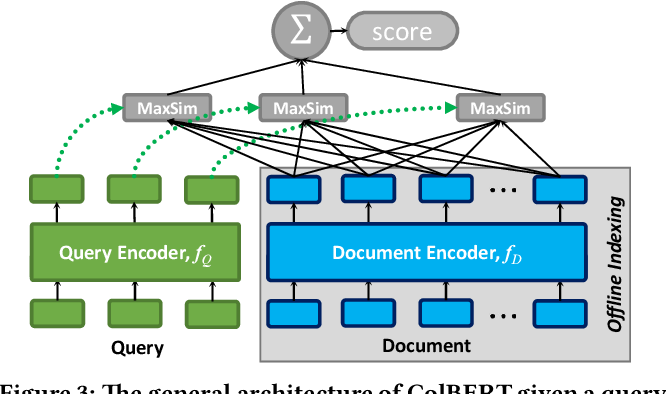 -->

In [52]:
!pip install llama-index-postprocessor-colbert-rerank
!pip install llama-index-postprocessor-sentence-transformers-rerank

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement llama-index-postprocessor-sentence-transformers-rerank (from versions: none)
ERROR: No matching distribution found for llama-index-postprocessor-sentence-transformers-rerank


In [53]:
from llama_index.postprocessor.colbert_rerank import ColbertRerank

colbert_reranker = ColbertRerank(
    top_n=2,
    model="colbert-ir/colbertv2.0",
    tokenizer="colbert-ir/colbertv2.0",
    keep_retrieval_score=True,
)

query_engine = index.as_query_engine(
    similarity_top_k=5,
    node_postprocessors=[colbert_reranker],
)

In [54]:
print(query_engine.query("What are some papers about video generation using diffusion models?"))

Context information is below.
---------------------
retrieval_score: 0.7594684708866163

VideoControlNet: A Motion-Guided Video-to-Video Translation Framework by   Using Diffusion Model with ControlNet 
 Recently, diffusion models like StableDiffusion have achieved impressive image generation results. However, the generation process of such diffusion models is uncontrollable, which makes it hard to generate videos with continuous and consistent content. In this work, by using the diffusion model with ControlNet, we proposed a new motion-guided video-to-video translation framework called VideoControlNet to generate various videos based on the given prompts and the condition from the input video. Inspired by the video codecs that use motion information for reducing temporal redundancy, our framework uses motion information to prevent the regeneration of the redundant areas for content consistency. Specifically, we generate the first frame (i.e., the I-frame) by using the diffusion model 

# Generation

Great! now we have all the retrieved context. Let's move on to the next step: Generation

In [55]:
# del model, tokenizer

In [56]:
from llama_index.llms.huggingface import HuggingFaceLLM

from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
     model_name = "unsloth/gemma-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
     max_seq_length = max_seq_length,
     dtype = dtype,
     load_in_4bit = load_in_4bit,
     device_map='cuda',
      token = ""
 )

llm = HuggingFaceLLM(model=model, tokenizer=tokenizer, context_window=4096, max_new_tokens=max_seq_length)

==((====))==  Unsloth: Fast Gemma patching release 2024.3
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


At this point in the process, the context we've retrieved is ready to be integrated into a prompt template. Conveniently, `llama_index` offers a default template to simplify this step. To access this standard template and potentially others available, you can use the `get_prompts` function. This function will provide you with the default prompt template, which you can then utilize or customize as needed for your specific application.

In [57]:
prompts_dict = query_engine.get_prompts()
print(list(prompts_dict.keys()))

['response_synthesizer:text_qa_template', 'response_synthesizer:refine_template']


Let's take a look at the system prompt

In [58]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[0].content)

You are an expert Q&A system that is trusted around the world.
Always answer the query using the provided context information, and not prior knowledge.
Some rules to follow:
1. Never directly reference the given context in your answer.
2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.


Now the user prompt

In [59]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[1].content)

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


In [60]:
print(prompts_dict['response_synthesizer:refine_template'].default_template.template)

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 


You can custom the system prompt and user prompt in `llama_index`, for now I just copy the default prompt, but you can custom your own prompt!!

In [61]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

system_prompt = """
You are an expert Q&A system that is trusted around the world.
Always answer the query using the provided context information, and not prior knowledge.
Some rules to follow:
1. Never directly reference the given context in your answer.
2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.
"""

user_prompt = """ 
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 
"""

refine_prompt = """
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 
"""

message_template = [
    ChatMessage(content=system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=user_prompt, role=MessageRole.USER)
]
prompt_template = PromptTemplate(user_prompt)
refine_template = PromptTemplate(refine_prompt)

In [62]:
query_engine = index.as_query_engine(
    llm=llm,
    similarity_top_k=5,
    node_postprocessors=[colbert_reranker],
)


query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": prompt_template, "response_synthesizer:refine_template": refine_template}
)

In [64]:
print(query_engine.query("List some paper about cancer research").response)

Yet, there's a wealth of possibilities still to explore. This is a working progress, stay tuned for future versions!!!

TODO List:
- [ ] Improve the data section with PDF parsing, more papers, and the paper body instead of just abstract.
- [ ] Improve the Indexing section with more chunking methods (Semantic Chunking). Dive into how the VectorStoreIndex works.
- [ ] Add LLM evaluation, LLM Rerank
